In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
import re
import tensorflow as tf
import nltk
import string
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from transformers import AutoTokenizer
import tensorflow_datasets as tfds
from datasets import Dataset
from transformers import TFAutoModelForTokenClassification, AutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import accuracy_score , confusion_matrix, f1_score
import json

In [2]:
ds = tfds.load('fashion_mnist', split='train')

In [3]:
ds.as_numpy_iterator().next()['label']

2

In [4]:
dataiterator = ds.as_numpy_iterator()
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

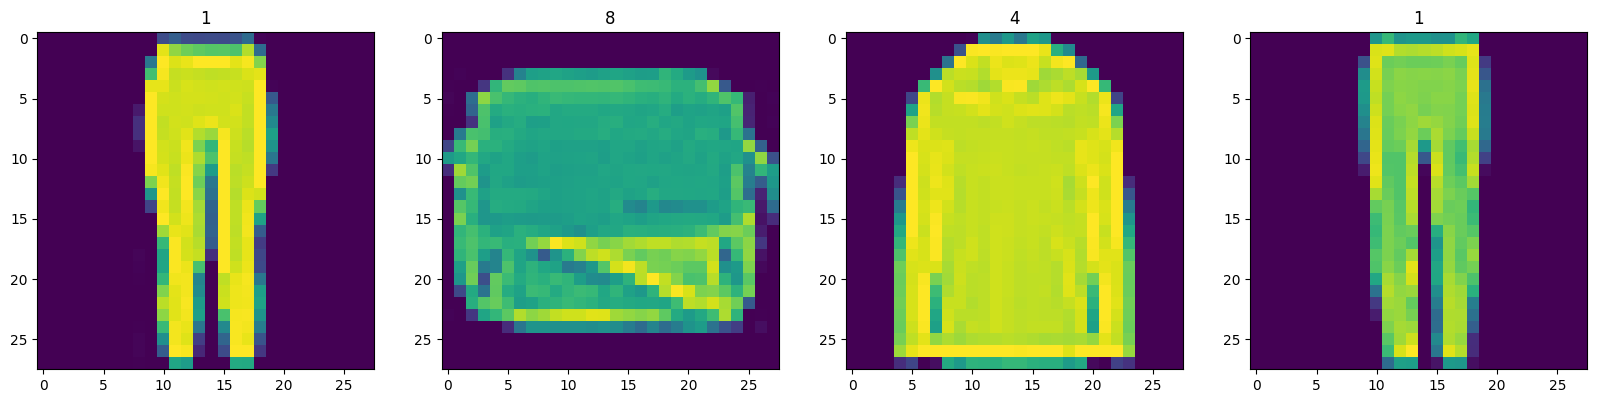

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [5]:
def scale_images(data): 
    image = data['image']
    return image / 255

In [6]:
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [7]:
def build_generator(): 
    model = Sequential()

    model.add(Dense(7*7*128, input_dim=128, activation=LeakyReLU(0.2)))
    model.add(Reshape((7,7,128)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(filters=128, kernel_size=(5,5), padding='same', activation=LeakyReLU(0.2)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(filters=128, kernel_size=(5,5), padding='same', activation=LeakyReLU(0.2)))
    
    model.add(Conv2D(filters=128, kernel_size=(4,4), padding='same', activation=LeakyReLU(0.2)))
    
    model.add(Conv2D(filters=128, kernel_size=(4,4), padding='same', activation=LeakyReLU(0.2)))
    
    model.add(Conv2D(filters=1, kernel_size=(4,4), padding='same', activation='sigmoid'))
    
    return model

In [8]:
generator = build_generator()

In [108]:
generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              809088    
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_13 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 up_sampling2d_14 (UpSamplin  (None, 28, 28, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 128)      

In [9]:
latent_vector = np.random.randn(4, 128)
img = generator.predict(latent_vector)

1/1 [==============================] - 2s 2s/step


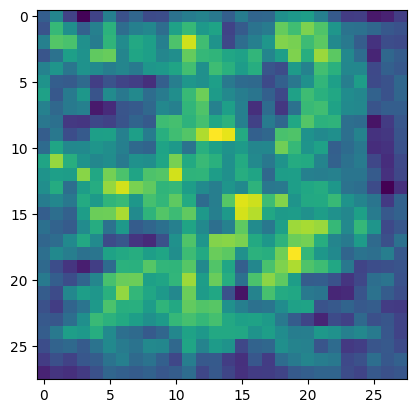

In [195]:
plt.imshow(np.squeeze(img))

1/1 [==============================] - 0s 12ms/step


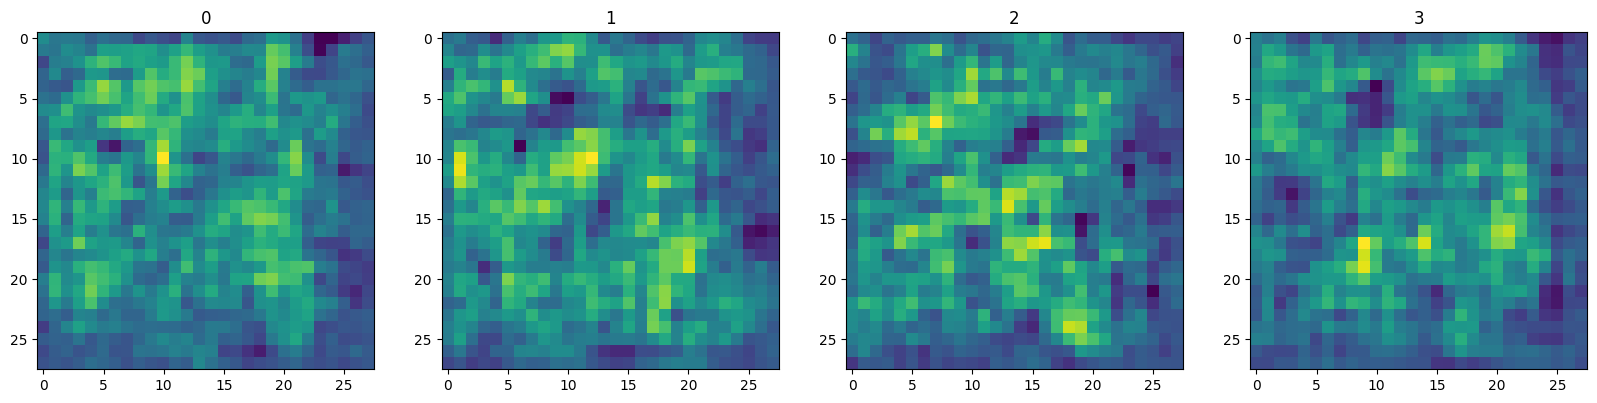

In [110]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):  
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

In [28]:
def build_discriminator(activation=LeakyReLU(0.2), padding='same'): 
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape = (28,28,1), activation=activation))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(filters=64, kernel_size=(4,4), activation=activation))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(filters=128, kernel_size=(4,4), activation=activation))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(filters=256, kernel_size=(4,4), activation=activation))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [29]:
discriminator = build_discriminator()

In [30]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 dropout_5 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 64)        32832     
                                                                 
 dropout_6 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 19, 19, 128)       131200    
                                                                 
 dropout_7 (Dropout)         (None, 19, 19, 128)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 256)      

In [15]:
img.shape

(4, 28, 28, 1)

In [31]:
discriminator.predict(img)

1/1 [==============================] - 0s 420ms/step


array([[0.51502854],
       [0.51488507],
       [0.5146137 ],
       [0.5147962 ]], dtype=float32)

In [32]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [33]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
       
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        with tf.GradientTape() as g_tape: 
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [34]:
fashgan = FashionGAN(generator, discriminator)

In [35]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [36]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

In [37]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [18]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 83s 163ms/step - d_loss: 0.5844 - g_loss: 0.7697
Epoch 2/20
469/469 [==============================] - 76s 163ms/step - d_loss: 0.6830 - g_loss: 0.7126
Epoch 3/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6901 - g_loss: 0.6553
Epoch 4/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6955 - g_loss: 0.6433
Epoch 5/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6913 - g_loss: 0.6506
Epoch 6/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6937 - g_loss: 0.6514
Epoch 7/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6905 - g_loss: 0.6518
Epoch 8/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6896 - g_loss: 0.6438
Epoch 9/20
469/469 [==============================] - 75s 161ms/step - d_loss: 0.5688 - g_loss: 1.1424
Epoch 10/20
469/469 [==============================] - 75s 160ms/step - d

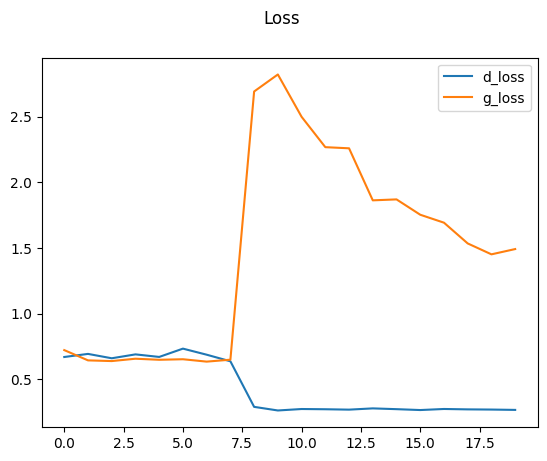

In [21]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 10ms/step


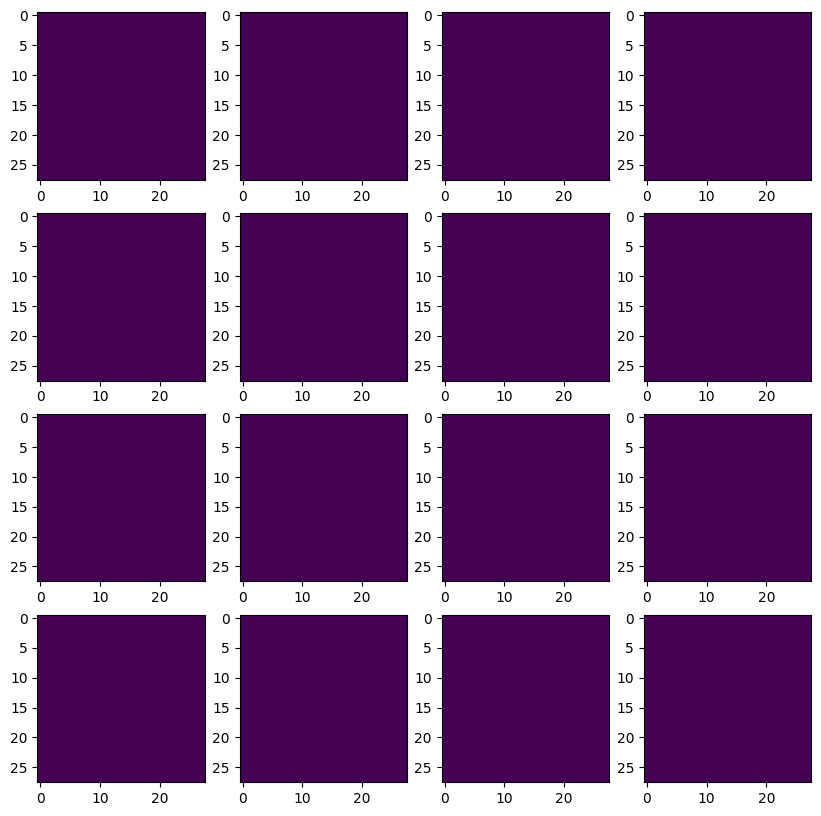

In [25]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])